### DoRothEA VS CollecTRI

&emsp;&emsp;&emsp;



<br></br>

### **Data Preparation**

In [ ]:
# Install necessary libraries
%pip install scanpy
%pip install decoupler
%pip install pydeseq2
%pip install adjustText
%pip install omnipath

In [ ]:
# Import Necessary libraries
import scanpy as sc
import decoupler as dc
import omnipath as op

# Data Manipulation
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy import stats

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Differential Expression Analysis (DESeq2)
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Retrieve CollecTRI gene regulatory network
try:
    collectri = dc.get_collectri(organism='human', split_complexes=False)
    collectri.to_csv("datasets/collectri.csv",index=False)
except:
    collectri = pd.read_table("datasets/collectri.csv", sep=',')
collectri

,source,target,weight
0,MYC,TERT,1
1,SPI1,BGLAP,1
2,SMAD3,JUN,1
3,SMAD4,JUN,1
4,STAT5A,IL2,1
...,...,...,...
43173,NFKB,hsa-miR-143-3p,1
43174,AP1,hsa-miR-206,1
43175,NFKB,hsa-miR-21-5p,1
43176,NFKB,hsa-miR-224-5p,1


In [ ]:
# Retrieve DoRothEA gene regulatory network
try:
    dorothea = dc.get_dorothea(organism='human')
    dorothea.to_csv("datasets/dorothea.csv",index=False)
except:
    dorothea = pd.read_table("datasets/dorothea.csv", sep=',')
dorothea

,source,confidence,target,weight
0,MYC,A,TERT,1.000000
1,FOS,A,NTS,1.000000
2,FOS,A,NTF3,1.000000
3,FOS,A,NFKB1,-1.000000
4,FOS,A,NEFL,1.000000
...,...,...,...,...
32270,LEF1,C,NKD1,0.333333
32271,LEF1,C,NETO2,0.333333
32272,LEF1,C,MYO18B,0.333333
32273,LEF1,C,PHLDB2,0.333333


In [ ]:
# Download the data from GEO
try:
    !wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz' -O counts.txt.gz
    !gzip -d -f counts.txt.gz
    !mkdir datasets
    !mv counts.txt datasets/counts.txt
except:
    print("Error! Please upload counts.txt file manually.")

# Read raw data and process it
adata_table = pd.read_csv('datasets/counts.txt', index_col=2, sep='\t').iloc[:, 5:].T
adata_table

--2023-09-08 03:31:29--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1578642 (1.5M) [application/octet-stream]
Saving to: ‘counts.txt.gz’

counts.txt.gz       100%[===================>]   1.50M  3.82MB/s    in 0.4s    

2023-09-08 03:31:30 (3.82 MB/s) - ‘counts.txt.gz’ saved [1578642/1578642]

mkdir: cannot create directory ‘datasets’: File exists


GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


In [ ]:
# Transform to AnnData object
adata = AnnData(adata_table, dtype=np.float32)
adata.var_names_make_unique()

# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X

# Visualize metadata
adata.obs

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32
33_HSCs-TGFb3,treatment,33


AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    layers: 'counts', 'cpm'

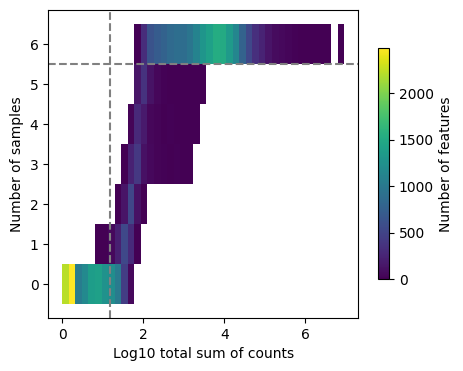

In [ ]:
# Quality Control (optional but recommended)
# --- only the genes in the upper-right corner are going to be kept
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata_filtered = adata[:, genes].copy()

# Normalize total-count per million, CPM (library-size correct)
sc.pp.normalize_total(adata_filtered, target_sum=1e6)

# Store normalized counts in layers
adata_filtered.layers['cpm'] = adata_filtered.X

# Visualize adata
adata_filtered

In [ ]:
# Convert anndata to dataframe
mat = adata_filtered.to_df(layer='cpm')
mat

GeneName,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,AC114498.1,MIR6723,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0.861613,0.600518,2.637059,1.305475,1.853774,0.496080,20.391516,51.644581,12.323682,628.011658,...,2433.196045,8.929447,12.428120,12.871981,1422.079712,448.665558,33.994560,1412.497559,6.736249,12.402010
26_HSCs-Ctrl2,1.341323,0.914539,2.581031,0.751954,0.975508,0.934862,18.026571,48.328281,9.734755,522.831543,...,2335.406250,7.214693,7.885355,8.860863,1314.862549,428.938904,30.322033,1273.830200,5.141739,8.047939
27_HSCs-Ctrl3,0.969110,0.633649,2.012767,0.838653,1.062294,0.465918,20.779961,56.823406,10.138384,572.576416,...,2895.496338,7.026049,8.162890,8.945633,1596.236328,593.766357,37.888481,1669.087402,5.255559,8.349257
31_HSCs-TGFb1,0.965408,0.536338,2.592299,0.500582,1.841426,0.536338,15.375017,44.802082,7.937799,367.212616,...,1982.054199,6.668467,7.884166,8.599282,1078.485962,348.548065,25.869360,1185.002563,3.075003,6.096373
32_HSCs-TGFb2,1.027534,0.653885,1.821537,0.607179,1.447888,0.607179,9.457981,26.295525,7.146030,227.505325,...,1062.283081,5.581377,7.729856,8.010093,640.854126,211.438431,14.572297,643.026001,2.241892,5.044257
33_HSCs-TGFb3,0.796692,0.522829,2.190902,0.423242,1.468900,0.248966,15.037556,47.253777,7.070639,369.415955,...,1760.290283,8.564435,11.278167,12.373617,1131.376831,343.473694,26.813654,1080.886475,4.780150,6.049877


In [ ]:
mat.apply([np.sum, np.min, np.max], axis=1)

,sum,amin,amax
25_HSCs-Ctrl1,1.000000e+06,0.234985,16724.437500
26_HSCs-Ctrl2,1.000000e+06,0.223554,20666.802734
27_HSCs-Ctrl3,1.000000e+06,0.223641,21531.746094
31_HSCs-TGFb1,1.000000e+06,0.232413,53465.296875
32_HSCs-TGFb2,1.000000e+06,0.233530,55140.593750
33_HSCs-TGFb3,1.000000e+06,0.224070,59497.929688


### **TASK 1** Without DEA

In [ ]:
# Infer TF activities with ulm using CollecTRI network
tf_collectri_acts, tf_collectri_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_collectri_acts
# tf_collectri_acts.apply([np.sum, np.min, np.max], axis=1)

Running ulm on mat with 6 samples and 17575 targets for 629 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91
25_HSCs-Ctrl1,1.065369,3.513768,-0.092619,9.416823,3.750810,7.374182,2.209627,0.792456,-0.073562,-0.119644,...,2.369821,1.127670,-0.358643,17.152018,-0.152018,0.223835,0.792804,-0.641132,-0.200024,1.450069
26_HSCs-Ctrl2,1.030500,3.439764,-0.108949,9.543247,3.511437,7.277483,2.080467,0.805713,-0.070083,-0.108495,...,2.047254,1.055401,-0.310071,19.226736,-0.127963,0.200891,0.684690,-0.659765,-0.191540,1.307216
27_HSCs-Ctrl3,1.062467,3.423932,-0.105873,9.529863,3.719286,7.011393,2.019213,0.803646,-0.044515,-0.098158,...,2.195279,1.095722,-0.281857,19.752375,-0.130376,0.231477,0.739110,-0.655897,-0.193930,1.433861
31_HSCs-TGFb1,0.341344,2.637449,-0.137243,9.362064,1.862120,8.492096,0.501636,0.297469,-0.033156,-0.101031,...,0.258564,0.462094,-0.082978,16.974936,-0.076635,0.083366,0.223191,-0.273286,-0.090176,0.539266
32_HSCs-TGFb2,0.341261,2.539009,-0.125790,9.223310,1.679006,8.553974,0.518021,0.306204,-0.041595,-0.098013,...,0.221584,0.438338,-0.116582,16.314453,-0.093113,0.047600,0.247142,-0.285474,-0.080971,0.547607
33_HSCs-TGFb3,0.310873,2.437673,-0.130148,9.481165,1.448070,8.715354,0.467010,0.262756,-0.043612,-0.103782,...,0.259061,0.411983,-0.123147,14.641565,-0.087410,0.042556,0.246827,-0.249543,-0.083871,0.495250


In [ ]:
# Infer TF activities with ulm using DoRothEA network
tf_dorothea_acts, tf_dorothea_pvals = dc.run_ulm(mat=mat, net=dorothea, verbose=True)
tf_dorothea_acts
# tf_dorothea_acts.apply([np.sum, np.min, np.max], axis=1)

Running ulm on mat with 6 samples and 17575 targets for 281 sources.


,AHR,AR,ARID2,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
25_HSCs-Ctrl1,1.021086,3.672184,0.669489,0.081744,2.697176,0.406037,1.640476,9.651978,0.612117,1.249952,...,1.153679,-0.362536,2.313812,-0.243042,1.458922,0.229469,0.236344,0.888968,-0.119325,0.818214
26_HSCs-Ctrl2,0.837120,3.125765,0.522897,0.059671,2.484155,0.425281,1.518833,11.370803,0.600986,1.228788,...,1.089787,-0.348231,2.313849,-0.225304,1.381332,0.223435,0.209429,0.743977,-0.103536,0.821655
27_HSCs-Ctrl3,0.733425,3.235074,0.362701,0.039755,2.302288,0.379323,1.453785,9.988415,0.632513,1.174859,...,0.941741,-0.352394,2.391270,-0.243336,1.257836,0.177968,0.197425,0.655634,-0.124677,0.821915
31_HSCs-TGFb1,0.146720,1.907997,0.176476,0.030676,1.489435,0.167627,0.882310,24.084148,0.323295,0.646517,...,0.294664,-0.155068,0.951346,-0.236343,0.557975,0.017112,0.024222,0.267927,-0.058889,0.247535
32_HSCs-TGFb2,0.142365,1.933520,0.198579,0.066514,1.523887,0.155074,0.908797,24.430395,0.302602,0.680592,...,0.323096,-0.145248,0.818233,-0.234875,0.546379,0.014626,0.004064,0.317364,-0.036936,0.213982
33_HSCs-TGFb3,0.148002,1.912735,0.190550,0.049040,1.451231,0.150502,0.834315,25.430475,0.284248,0.620383,...,0.334270,-0.142322,0.814429,-0.233602,0.530376,0.006014,-0.006023,0.318174,-0.029797,0.211474


In [ ]:
# Filter p-value < 0.05 in collectri TF activity
tf_collectri_acts_filtered = tf_collectri_acts.loc[:, tf_collectri_pvals.lt(0.05).all()]
tf_collectri_acts_filtered.shape

(6, 173)

In [ ]:
# Filter p-value < 0.05 in dorothea TF activity
tf_dorothea_acts_filtered = tf_dorothea_acts.loc[:, tf_dorothea_pvals.lt(0.05).all()]
tf_dorothea_acts_filtered.shape

(6, 57)

In [ ]:
# Find common columns
matched_columns = tf_collectri_acts.columns.intersection(tf_dorothea_acts.columns)

# Merge two dataframes based on the matched columns
df_merged = pd.merge(tf_collectri_acts[matched_columns], tf_dorothea_acts[matched_columns], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))

df_merged

,AHR_collectri,AR_collectri,ARID3A_collectri,ARNT_collectri,ASCL1_collectri,ATF1_collectri,ATF2_collectri,ATF3_collectri,ATF4_collectri,ATF6_collectri,...,YY1_dorothea,ZBED1_dorothea,ZBTB33_dorothea,ZBTB7A_dorothea,ZEB1_dorothea,ZEB2_dorothea,ZHX2_dorothea,ZNF143_dorothea,ZNF263_dorothea,ZNF384_dorothea
25_HSCs-Ctrl1,3.513768,7.374182,0.792456,1.198286,2.654510,2.785471,6.056330,5.635913,3.636624,2.615047,...,0.120190,0.830525,1.316495,3.326636,7.565924,5.333564,1.066102,0.994266,2.313812,1.458922
26_HSCs-Ctrl2,3.439764,7.277483,0.805713,1.125570,2.602200,2.350424,6.752047,6.186154,3.380385,2.349293,...,0.217628,0.697476,1.146904,3.190058,7.463633,5.112087,0.990801,1.010280,2.313849,1.381332
27_HSCs-Ctrl3,3.423932,7.011393,0.803646,1.120977,2.618362,2.621725,6.114440,5.627210,3.414000,2.376799,...,0.147464,0.715901,1.008755,3.540641,7.073108,5.214593,1.036648,1.007952,2.391270,1.257836
31_HSCs-TGFb1,2.637449,8.492096,0.297469,1.458125,1.839883,-0.137174,12.579825,13.259231,1.412705,1.391680,...,0.387686,0.173485,0.386527,1.383568,5.270473,2.422393,0.286207,0.401297,0.951346,0.557975
32_HSCs-TGFb2,2.539009,8.553974,0.306204,1.344882,1.748260,-0.229812,12.704719,13.202457,1.277132,1.351969,...,0.391979,0.165230,0.429917,1.166487,5.183165,2.139276,0.290495,0.342633,0.818233,0.546379
33_HSCs-TGFb3,2.437673,8.715354,0.262756,1.456021,1.636797,-0.143629,13.176441,14.049950,1.349135,1.276085,...,0.372879,0.147714,0.397987,1.039810,5.175720,2.219488,0.273864,0.341225,0.814429,0.530376


In [ ]:
# Find common columns
matched_columns_filtered = tf_collectri_acts_filtered.columns.intersection(tf_dorothea_acts_filtered.columns)

# Merge two dataframes based on the matched columns
df_merged_filtered = pd.merge(tf_collectri_acts_filtered[matched_columns_filtered], tf_dorothea_acts_filtered[matched_columns_filtered], left_index=True, right_index=True, suffixes=('_collectri', '_dorothea'))

df_merged_filtered

,ATF2_collectri,CEBPA_collectri,CEBPD_collectri,CREB1_collectri,EGR1_collectri,EPAS1_collectri,ESR1_collectri,ETS1_collectri,ETV4_collectri,FOS_collectri,...,SP1_dorothea,SP3_dorothea,SPI1_dorothea,SRF_dorothea,STAT1_dorothea,TBP_dorothea,TFAP2A_dorothea,TWIST1_dorothea,USF1_dorothea,USF2_dorothea
25_HSCs-Ctrl1,6.056330,8.215017,12.066716,4.755984,13.301751,5.399525,7.085041,14.381563,4.153017,6.428141,...,7.735653,13.983871,4.112229,15.509757,9.836035,14.597396,11.111717,4.925829,4.796582,5.820758
26_HSCs-Ctrl2,6.752047,8.492769,13.137196,5.057590,14.168164,5.133511,6.670248,15.632476,3.927345,6.732810,...,7.385869,14.917742,3.895115,15.067191,10.011469,17.094852,10.254299,4.362162,4.732239,5.762555
27_HSCs-Ctrl3,6.114440,8.557335,13.533414,4.855953,14.076419,5.307034,6.840119,15.508755,4.085566,6.345921,...,7.087571,15.393705,3.607999,15.241090,10.083284,15.343170,10.903830,4.261085,4.842383,5.489714
31_HSCs-TGFb1,12.579825,10.044015,10.411624,7.482423,15.055024,3.774556,3.922930,17.165949,2.378347,10.100188,...,8.689702,13.517368,2.119456,12.022268,7.619104,35.416481,4.019162,3.815943,4.029725,5.040974
32_HSCs-TGFb2,12.704719,9.849190,9.993420,7.463739,14.845440,3.582222,3.836319,16.888117,2.262217,10.148149,...,8.812040,13.180999,2.234537,11.524851,7.494651,35.726379,3.740860,3.851121,3.700996,4.968072
33_HSCs-TGFb3,13.176441,10.455815,9.000201,7.759928,14.868939,3.514696,3.788261,16.933939,2.132518,10.375518,...,9.433439,12.157229,2.192419,10.800351,6.977996,37.195339,3.848060,3.530662,3.859724,4.681488


In [ ]:
# 2. Filtering to get the target column
regulons_collectri_selected = collectri.loc[collectri['source'] == "RELA", 'target']
# 3. Filtering the 'mat' DataFrame
df_mat_collectri_selected = mat[regulons_collectri_selected[regulons_collectri_selected.isin(mat.columns)].to_list()]

df_mat_collectri_selected

GeneName,FAS,ABCB1,JAG1,TP53,CCND1,PLAU,CXCL8,IL6,ICAM1,VCAM1,...,JUN,CASP8,FOSL1,CAV1,CYBA,PGF,GALK1,SNAI2,HSPA1A,HSPA1B
25_HSCs-Ctrl1,54.803829,1.801555,36.057213,61.357311,1112.107788,614.434753,70.521744,8.694462,55.352127,70.704514,...,111.983620,20.522062,57.023136,641.719177,49.399162,0.626628,15.247945,82.845428,39.503666,38.615944
26_HSCs-Ctrl2,51.478359,1.910369,32.598217,64.952560,1222.656738,581.402649,53.327759,7.885355,74.484085,42.556526,...,117.020287,18.107862,79.097420,684.196777,43.166218,0.589369,14.856171,69.504929,42.902020,39.772266
27_HSCs-Ctrl3,48.064140,0.987747,30.787886,64.129005,1372.353271,632.586731,58.407528,6.839682,68.955917,66.626328,...,127.661636,17.164433,88.133118,690.565613,48.418240,0.559102,15.505764,70.316399,40.833088,36.770279
31_HSCs-TGFb1,30.821545,0.250291,13.533590,38.938126,876.125671,98.114059,12.228501,12.639694,8.688672,0.911774,...,69.992081,9.439546,41.584057,607.348938,33.682014,0.947530,11.406117,40.958328,41.083473,32.484192
32_HSCs-TGFb2,31.526606,0.326943,13.404645,33.885262,759.230713,92.478043,14.362120,13.825000,11.583108,1.074240,...,65.388512,11.372931,33.511612,666.402344,29.261360,0.397002,9.925042,45.141426,38.345692,29.121243
33_HSCs-TGFb3,30.896698,0.448139,13.991898,31.145664,868.792297,95.827072,16.108110,14.265760,10.655751,1.419107,...,68.266518,8.390160,31.892563,628.888489,30.174698,0.622415,10.332095,42.249554,34.307533,27.311586


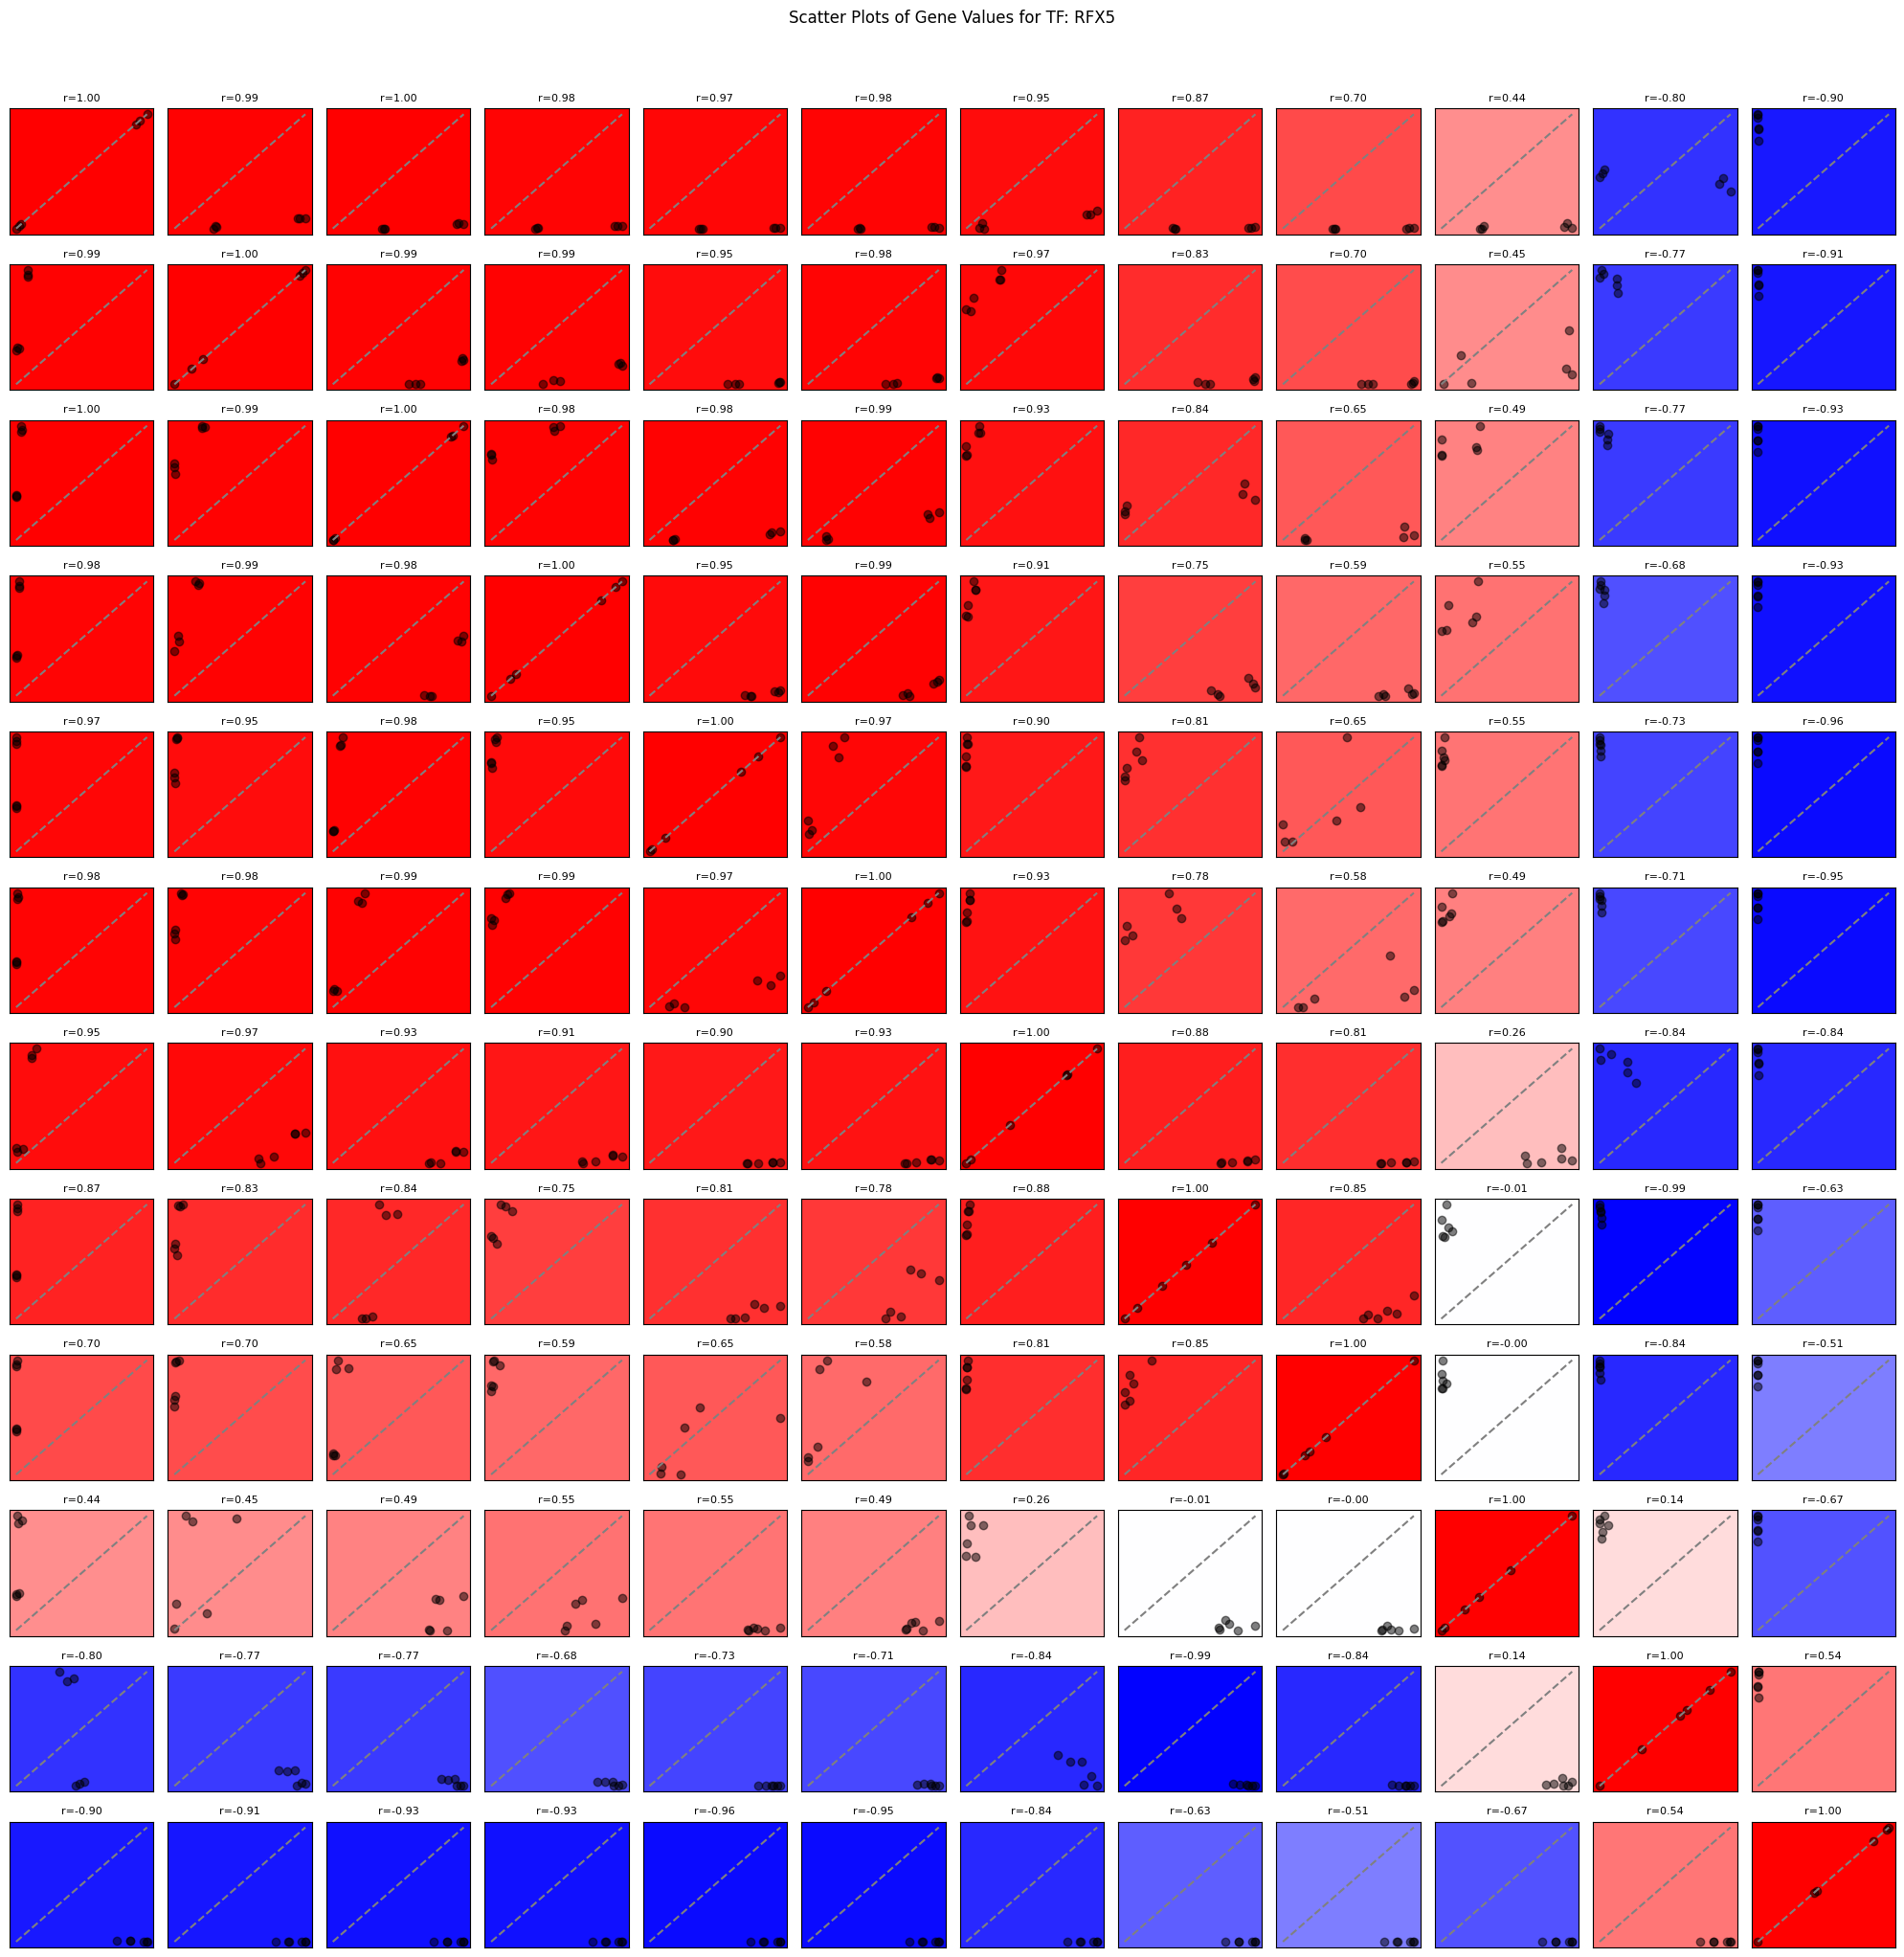

In [ ]:
tf = "RFX5"

# 2. Filtering to get the target column
regulons_collectri = collectri.loc[collectri['source'] == tf, 'target']
regulons_dorothea = dorothea.loc[dorothea['source'] == tf, 'target']

# 3. Filtering the 'mat' DataFrame
df_mat_collectri = mat[regulons_collectri[regulons_collectri.isin(mat.columns)].to_list()]
df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.isin(mat.columns)].to_list()]

# 4. Compute the Pearson correlation
correlation_collectri = df_mat_collectri.corr()
correlation_dorothea = df_mat_dorothea.corr()

# Sort the correlation matrices by the average correlation value
sorted_columns_collectri = correlation_collectri.mean().sort_values(ascending=False).index
sorted_columns_dorothea = correlation_dorothea.mean().sort_values(ascending=False).index

correlation_collectri = correlation_collectri.loc[sorted_columns_collectri, sorted_columns_collectri]
correlation_dorothea = correlation_dorothea.loc[sorted_columns_dorothea, sorted_columns_dorothea]

# Reorder the columns of df_mat_collectri to match the order in correlation_collectri
df_mat_collectri = df_mat_collectri[correlation_collectri.columns]

# Number of genes
n_genes = df_mat_collectri.shape[1]

# Create a grid of subplots
fig, axes = plt.subplots(n_genes, n_genes, figsize=(20, 20))

# Set a global title
fig.suptitle(f'Scatter Plots of Gene Values for TF: {tf}', y=1.02)

for i in range(n_genes):
    for j in range(n_genes):
        # Plotting scatter for each gene vs. each gene
        axes[i, j].scatter(df_mat_collectri.iloc[:, i], df_mat_collectri.iloc[:, j], color='black', alpha=0.5)

        # Plot the 45-degree line
        min_val = min(df_mat_collectri.iloc[:, i].min(), df_mat_collectri.iloc[:, j].min())
        max_val = max(df_mat_collectri.iloc[:, i].max(), df_mat_collectri.iloc[:, j].max())
        axes[i, j].plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--')

        # Fetch the correlation value from correlation_collectri
        corr_value = correlation_collectri.iloc[i, j]

        # Set background color based on the correlation value using a colormap (blue-white-red)
        axes[i, j].set_facecolor(plt.cm.bwr((corr_value + 1) / 2)) # normalize corr_value to [0,1]

        # Set the title as the correlation value
        axes[i, j].set_title(f'r={corr_value:.2f}', fontsize=8)

        # Hide x and y ticks for clarity
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Adjust layout for clarity
plt.tight_layout()
plt.show()

In [ ]:

tf_lists = matched_columns_filtered.to_list()

# Placeholder for means
means = []

# Placeholder for Jaccard Index values
jaccard_indices = []

# 1. Loop through each TF in tf_lists:
for tf in tf_lists:
    # 2. Filtering to get the target column
    regulons_collectri = collectri.loc[collectri['source'] == tf, 'target']
    regulons_dorothea = dorothea.loc[dorothea['source'] == tf, 'target']

    # 3. Filtering the 'mat' DataFrame
    df_mat_collectri = mat[regulons_collectri[regulons_collectri.isin(mat.columns)].to_list()]
    df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.isin(mat.columns)].to_list()]

    # 4. Compute the Pearson correlation
    correlation_collectri = df_mat_collectri.corr()
    correlation_dorothea = df_mat_dorothea.corr()

    # Sort the correlation matrices by the average correlation value
    sorted_columns_collectri = correlation_collectri.mean().sort_values(ascending=False).index
    sorted_columns_dorothea = correlation_dorothea.mean().sort_values(ascending=False).index

    correlation_collectri = correlation_collectri.loc[sorted_columns_collectri, sorted_columns_collectri]
    correlation_dorothea = correlation_dorothea.loc[sorted_columns_dorothea, sorted_columns_dorothea]

    # Compute the intersection and union of the two regulons lists
    intersection = len(set(regulons_collectri).intersection(set(regulons_dorothea)))
    union = len(set(regulons_collectri).union(set(regulons_dorothea)))

    # Calculate Jaccard Index
    jaccard_index = intersection / union if union != 0 else 0
    jaccard_indices.append([tf, jaccard_index])

    # Calculate the mean correlation and store
    # Extract upper triangle of the matrix (excluding the diagonal)
    upper_triangle_collectri = correlation_collectri.where(np.triu(np.ones(correlation_collectri.shape), k=1).astype(bool))
    # Compute the mean of the upper triangle values
    mean_collectri = upper_triangle_collectri.stack().mean()

    # Extract upper triangle of the matrix (excluding the diagonal)
    upper_triangle_dorothea = correlation_dorothea.where(np.triu(np.ones(correlation_dorothea.shape), k=1).astype(bool))
    # Compute the mean of the upper triangle values
    mean_dorothea = upper_triangle_dorothea.stack().mean()

    means.append([tf, mean_collectri, mean_dorothea])

    # Plot correlation matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(correlation_collectri, ax=ax1, cmap='coolwarm')
    ax1.set_title(f"{tf} - Collectri (r={mean_collectri:.2f})")
    sns.heatmap(correlation_dorothea, ax=ax2, cmap='coolwarm')
    ax2.set_title(f"{tf} - Dorothea (r={mean_dorothea:.2f})")
    plt.tight_layout()
    plt.show()

print('Done.')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Convert means to DataFrame
correlation_mean = pd.DataFrame(means, columns=["TF", "regulons_collectri", "regulons_dorothea"])

# Convert Jaccard Indices to DataFrame
jaccard_df = pd.DataFrame(jaccard_indices, columns=["TF", "Jaccard Index"])

# Merge the correlation_mean and jaccard_df based on TF
merged_data = pd.merge(correlation_mean, jaccard_df, on='TF')

# Calculate the mean of each column
mean_collectri = tf_collectri_acts_filtered.mean()
mean_dorothea = tf_dorothea_acts_filtered.mean()

# Find overlapping column names
overlap_columns = mean_collectri.index.intersection(mean_dorothea.index).tolist()

# Construct a new dataframe
result_df = pd.DataFrame({
    'TF': overlap_columns,
    'tf_collectri': mean_collectri[overlap_columns],
    'tf_dorothea': mean_dorothea[overlap_columns]
})

# Merge to get the sorting order from earlier data (based on Jaccard Index)
merged_result = result_df.reset_index(drop=True).merge(merged_data, on='TF', how='inner')

# Adding a new column for marker type based on the conditions provided
conditions = [
    (merged_result['tf_collectri'] > 0) & (merged_result['tf_dorothea'] > 0),
    (merged_result['tf_collectri'] < 0) & (merged_result['tf_dorothea'] < 0),
    (merged_result['tf_collectri'] > 0) & (merged_result['tf_dorothea'] < 0),
    (merged_result['tf_collectri'] < 0) & (merged_result['tf_dorothea'] > 0)
]

choices = ['o', 's', '^', 'v'] # circle, square, triangle_up, triangle_down

merged_result['marker'] = np.select(conditions, choices, default='o')

def classify_tf_group(row):
    tf_col = row['tf_collectri']
    tf_dor = row['tf_dorothea']

    if tf_col > 0 and tf_dor > 0:
        if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
            return 2
        elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10 :
            return 3
        else:
            return 1
    elif tf_col < 0 and tf_dor < 0:
        if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
            return 5
        elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10 :
            return 6
        else:
            return 4
    elif tf_col > 0 and tf_dor < 0:
        return 7
    elif tf_col < 0 and tf_dor > 0:
        return 8

merged_result['tf_group'] = merged_result.apply(classify_tf_group, axis=1)

# Sort the merged data by Jaccard Index in descending order
merged_result = merged_result.sort_values(by='Jaccard Index', ascending=False)

# # Create a colormap based on unique TFs
# cmap = sns.color_palette('hls', n_colors=len(merged_result['TF'].unique()))
# color_dict = dict(zip(merged_result['TF'].unique(), cmap))

# Create a colormap based on unique tf_group
# Green, Red, Orange, Blue, Purple, Pink, Dark Grey, Light Grey
cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]
color_dict = dict(zip(np.linspace(1,len(cmap),num=len(cmap)), cmap))

merged_result.to_csv("merged_result_33.csv",index=False)
merged_result

,TF,tf_collectri,tf_dorothea,regulons_collectri,regulons_dorothea,Jaccard Index,marker,tf_group
18,RELA,3.242743,-12.932334,0.116831,0.052579,0.265723,^,7
23,SP1,10.333795,8.190713,0.099391,0.069247,0.245500,o,2
31,USF1,6.551861,4.326942,0.107549,0.140904,0.237037,o,2
32,USF2,3.730333,5.293927,0.056912,0.265408,0.215789,o,3
10,HIF1A,10.270652,5.752247,0.050332,0.018709,0.214405,o,2
14,NFIC,19.227777,19.464254,0.077624,0.115969,0.185185,o,1
24,SP3,12.218662,13.858485,0.082715,-0.014660,0.175166,o,1
29,TFAP2A,10.561103,7.312988,0.113237,0.086175,0.175066,o,2
11,JUN,14.150037,4.122874,0.127315,0.077980,0.174900,o,2
22,SMAD4,22.575455,2.824253,-0.008565,0.058120,0.171123,o,2


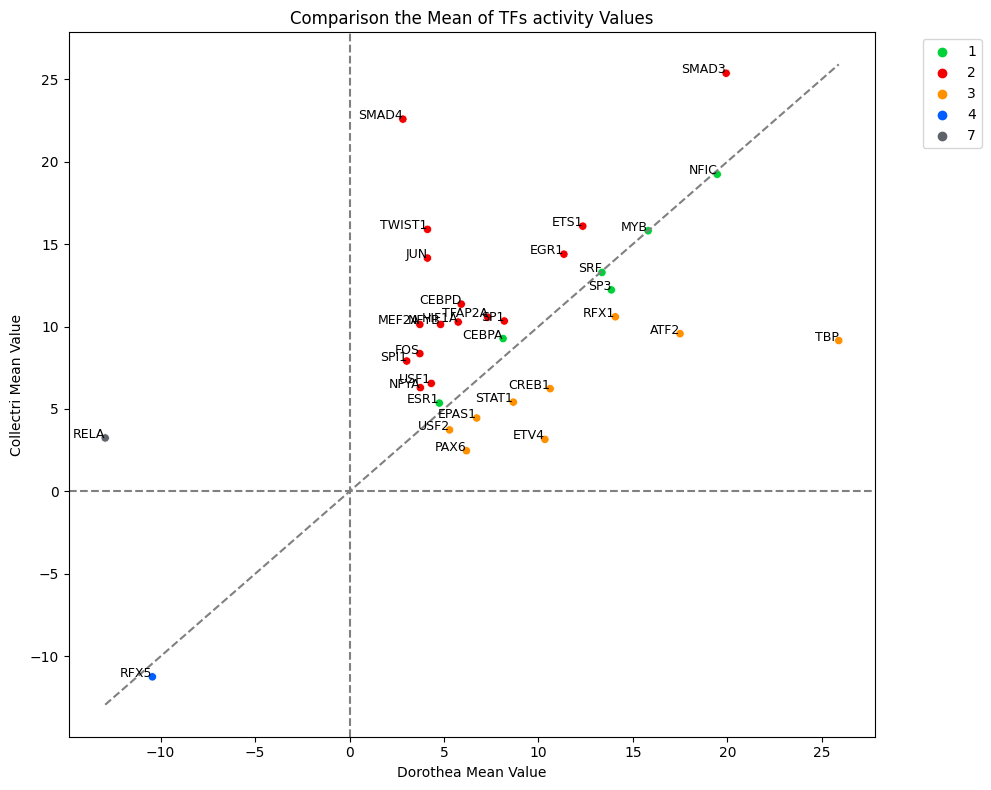

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_result, x="tf_dorothea", y="tf_collectri", hue="tf_group", palette=color_dict)
# sns.scatterplot(data=merged_result, x="tf_dorothea", y="tf_collectri", hue="TF", palette=color_dict)
# Add TF names as text on the graph
for index, row in merged_result.iterrows():
    plt.text(row['tf_dorothea'], row['tf_collectri'], row['TF'], fontsize=9, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
# 45-degree line
plt.plot([min(merged_result["tf_dorothea"].min(), merged_result["tf_collectri"].min()),
          max(merged_result["tf_dorothea"].max(), merged_result["tf_collectri"].max())],
         [min(merged_result["tf_dorothea"].min(), merged_result["tf_collectri"].min()),
          max(merged_result["tf_dorothea"].max(), merged_result["tf_collectri"].max())],
         color='gray', linestyle='--')
plt.title("Comparison the Mean of TFs activity Values")
plt.xlabel("Dorothea Mean Value")
plt.ylabel("Collectri Mean Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

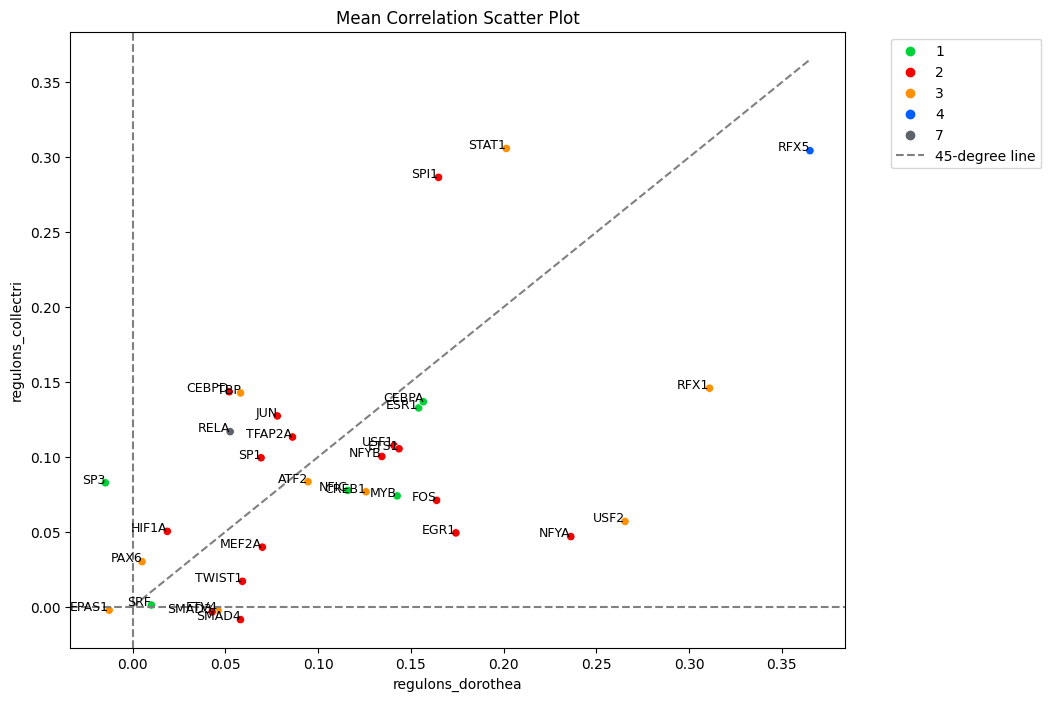

In [ ]:
# Plot the scatter
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_result, x="regulons_dorothea", y="regulons_collectri", hue="tf_group", palette=color_dict, legend="full")
# sns.scatterplot(data=merged_result, x="regulons_dorothea", y="regulons_collectri", hue="TF", palette=color_dict, legend="full")
# Add TF names as text on the graph
for index, row in merged_result.iterrows():
    plt.text(row['regulons_dorothea'], row['regulons_collectri'], row['TF'], fontsize=9, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
# Adding the 45-degree line
max_val = max(merged_result["regulons_dorothea"].max(), merged_result["regulons_collectri"].max())
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label="45-degree line")
plt.title("Mean Correlation Scatter Plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


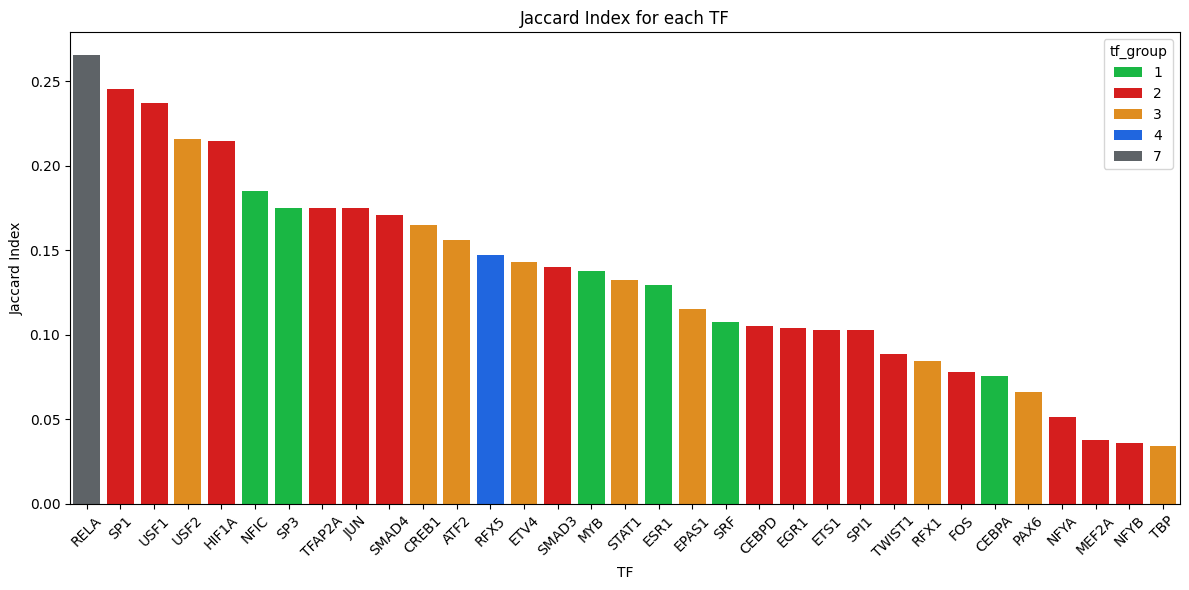

In [ ]:
# 8. Plot bar graph of Jaccard Indices
plt.figure(figsize=(12, 6))
sns.barplot(data=merged_result, x="TF", y="Jaccard Index", hue="tf_group", palette=color_dict, dodge=False)
plt.title("Jaccard Index for each TF")
plt.ylabel("Jaccard Index")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

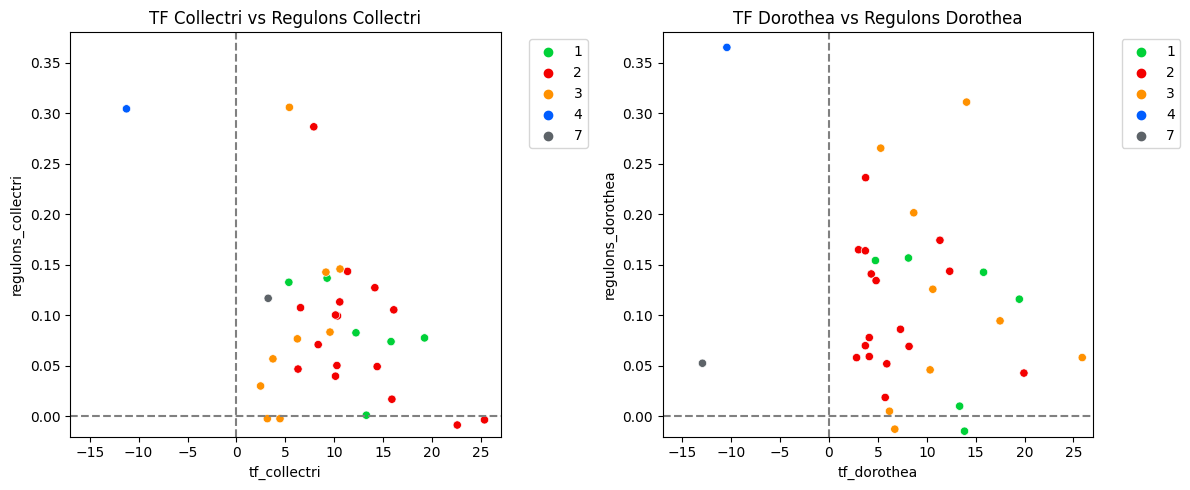

In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Getting the limits for axes
lim = max(abs(merged_result[['tf_collectri', 'tf_dorothea', 'regulons_collectri', 'regulons_dorothea']].values.flatten()))

# Plot for tf_collectri vs regulons_collectri
sns.scatterplot(data=merged_result, x="tf_collectri", y="regulons_collectri",
                hue="tf_group", palette=color_dict, ax=axes[0]) # , style="marker", markers=marker_dict
axes[0].set_title("TF Collectri vs Regulons Collectri")
axes[0].legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].axhline(0, color='gray', linestyle='--')
axes[0].axvline(0, color='gray', linestyle='--')
axes[0].set_xlim(-17, 27)
axes[0].set_ylim(-0.02, 0.38)

# Plot for tf_dorothea vs regulons_dorothea
sns.scatterplot(data=merged_result, x="tf_dorothea", y="regulons_dorothea",
                hue="tf_group", palette=color_dict, ax=axes[1]) # , style="marker", markers=marker_dict
axes[1].set_title("TF Dorothea vs Regulons Dorothea")
axes[1].legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].axvline(0, color='gray', linestyle='--')
axes[1].set_xlim(-17, 27)
axes[1].set_ylim(-0.02, 0.38)

plt.tight_layout()
plt.show()


##### Set 241 TFs

In [ ]:

tf_lists = matched_columns.to_list()

# Placeholder for means
means = []

# Placeholder for Jaccard Index values
jaccard_indices = []

# 1. Loop through each TF in tf_lists:
for tf in tf_lists:
    # 2. Filtering to get the target column
    regulons_collectri = collectri.loc[collectri['source'] == tf, 'target']
    regulons_dorothea = dorothea.loc[dorothea['source'] == tf, 'target']

    # 3. Filtering the 'mat' DataFrame
    df_mat_collectri = mat[regulons_collectri[regulons_collectri.isin(mat.columns)].to_list()]
    df_mat_dorothea = mat[regulons_dorothea[regulons_dorothea.isin(mat.columns)].to_list()]

    # 4. Compute the Pearson correlation
    correlation_collectri = df_mat_collectri.corr()
    correlation_dorothea = df_mat_dorothea.corr()

    # Sort the correlation matrices by the average correlation value
    sorted_columns_collectri = correlation_collectri.mean().sort_values(ascending=False).index
    sorted_columns_dorothea = correlation_dorothea.mean().sort_values(ascending=False).index

    correlation_collectri = correlation_collectri.loc[sorted_columns_collectri, sorted_columns_collectri]
    correlation_dorothea = correlation_dorothea.loc[sorted_columns_dorothea, sorted_columns_dorothea]

    # Compute the intersection and union of the two regulons lists
    intersection = len(set(regulons_collectri).intersection(set(regulons_dorothea)))
    union = len(set(regulons_collectri).union(set(regulons_dorothea)))

    # Calculate Jaccard Index
    jaccard_index = intersection / union if union != 0 else 0
    jaccard_indices.append([tf, jaccard_index])

    # Calculate the mean correlation and store
    # Extract upper triangle of the matrix (excluding the diagonal)
    upper_triangle_collectri = correlation_collectri.where(np.triu(np.ones(correlation_collectri.shape), k=1).astype(bool))
    # Compute the mean of the upper triangle values call
    mean_collectri = upper_triangle_collectri.stack().mean()

    # Extract upper triangle of the matrix (excluding the diagonal)
    upper_triangle_dorothea = correlation_dorothea.where(np.triu(np.ones(correlation_dorothea.shape), k=1).astype(bool))
    # Compute the mean of the upper triangle values
    mean_dorothea = upper_triangle_dorothea.stack().mean()

    means.append([tf, mean_collectri, mean_dorothea])

    # # Plot correlation matrices
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # sns.heatmap(correlation_collectri, ax=ax1, cmap='coolwarm')
    # ax1.set_title(f"{tf} - Collectri (r={mean_collectri:.2f})")
    # sns.heatmap(correlation_dorothea, ax=ax2, cmap='coolwarm')
    # ax2.set_title(f"{tf} - Dorothea (r={mean_dorothea:.2f})")
    # plt.tight_layout()
    # plt.show()

print('Done.')

Done.


In [ ]:
# Convert means to DataFrame
correlation_mean = pd.DataFrame(means, columns=["TF", "regulons_collectri", "regulons_dorothea"])

# Convert Jaccard Indices to DataFrame
jaccard_df = pd.DataFrame(jaccard_indices, columns=["TF", "Jaccard Index"])

# Merge the correlation_mean and jaccard_df based on TF
merged_data = pd.merge(correlation_mean, jaccard_df, on='TF')

# Calculate the mean of each column
mean_collectri = tf_collectri_acts.mean()
mean_dorothea = tf_dorothea_acts.mean()

# Find overlapping column names
overlap_columns = mean_collectri.index.intersection(mean_dorothea.index).tolist()

# Construct a new dataframe
result_df = pd.DataFrame({
    'TF': overlap_columns,
    'tf_collectri': mean_collectri[overlap_columns],
    'tf_dorothea': mean_dorothea[overlap_columns]
})

# Merge to get the sorting order from earlier data (based on Jaccard Index)
merged_result = result_df.reset_index(drop=True).merge(merged_data, on='TF', how='inner')

# Adding a new column for marker type based on the conditions provided
conditions = [
    (merged_result['tf_collectri'] > 0) & (merged_result['tf_dorothea'] > 0),
    (merged_result['tf_collectri'] < 0) & (merged_result['tf_dorothea'] < 0),
    (merged_result['tf_collectri'] > 0) & (merged_result['tf_dorothea'] < 0),
    (merged_result['tf_collectri'] < 0) & (merged_result['tf_dorothea'] > 0)
]

choices = ['o', 's', '^', 'v'] # circle, square, triangle_up, triangle_down

merged_result['marker'] = np.select(conditions, choices, default='o')

def classify_tf_group(row):
    tf_col = row['tf_collectri']
    tf_dor = row['tf_dorothea']

    if tf_col > 0 and tf_dor > 0:
        if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
            return 2
        elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10 :
            return 3
        else:
            return 1
    elif tf_col < 0 and tf_dor < 0:
        if (tf_col - tf_dor) / (tf_col + tf_dor) > 0.10:
            return 5
        elif (tf_dor - tf_col) / (tf_col + tf_dor) > 0.10 :
            return 6
        else:
            return 4
    elif tf_col > 0 and tf_dor < 0:
        return 7
    elif tf_col < 0 and tf_dor > 0:
        return 8

merged_result['tf_group'] = merged_result.apply(classify_tf_group, axis=1)

# Find common TFs
common_tfs = tf_collectri_pvals.columns.intersection(tf_dorothea_pvals.columns)

# Filter the p-values for the common TFs
common_tf_collectri_pvals = tf_collectri_pvals[common_tfs]
common_tf_dorothea_pvals = tf_dorothea_pvals[common_tfs]

# Group the TFs based on the conditions provided:
matched_columns_1 = common_tfs[(common_tf_collectri_pvals < 0.05).all() & (common_tf_dorothea_pvals < 0.05).all()]
matched_columns_2 = common_tfs[(common_tf_collectri_pvals < 0.05).all() & (common_tf_dorothea_pvals >= 0.05).all()]
matched_columns_3 = common_tfs[(common_tf_collectri_pvals >= 0.05).all() & (common_tf_dorothea_pvals < 0.05).all()]
matched_columns_4 = common_tfs[(common_tf_collectri_pvals >= 0.05).all() & (common_tf_dorothea_pvals >= 0.05).all()]

# Group the TFs based on the conditions provided:
# matched_columns_1 = common_tfs[common_tf_collectri_pvals.lt(0.05).all() & common_tf_dorothea_pvals.lt(0.05).all()]
# matched_columns_2 = common_tfs[common_tf_collectri_pvals.lt(0.05).all() & common_tf_dorothea_pvals.gt(0.05).all()]
# matched_columns_3 = common_tfs[common_tf_collectri_pvals.gt(0.05).all() & common_tf_dorothea_pvals.lt(0.05).all()]
# matched_columns_4 = common_tfs[common_tf_collectri_pvals.gt(0.05).all() & common_tf_dorothea_pvals.gt(0.05).all()]

# Create a dictionary to map the column names to their corresponding markers
tf_to_marker = {}

# Populate the dictionary with the markers for each group
for tf in matched_columns_1:
    tf_to_marker[tf] = 'o'
for tf in matched_columns_2:
    tf_to_marker[tf] = '^'
for tf in matched_columns_3:
    tf_to_marker[tf] = 'v'
for tf in matched_columns_4:
    tf_to_marker[tf] = 's'

# Use the map function to update the 'tf_significant' column based on the 'TF' column
merged_result['tf_significant'] = merged_result['TF'].map(tf_to_marker).fillna("s")

# tf_lists_selected = matched_columns_filtered.to_list()
# merged_result['tf_significant'] = merged_result['TF'].apply(lambda x: 'o' if x in tf_lists_selected else '^')

# Sort the merged data by Jaccard Index in descending order
merged_result = merged_result.sort_values(by='Jaccard Index', ascending=False)

# # Create a colormap based on unique TFs
# cmap = sns.color_palette('hls', n_colors=len(merged_result['TF'].unique()))
# color_dict = dict(zip(merged_result['TF'].unique(), cmap))

# Create a colormap based on unique tf_group
# Green, Red, Orange, Blue, Purple, Pink, Dark Grey, Light Grey
cmap = ["#00d138","#f30000","#ff9100","#005dff","#9d2bff","#ff35e5","#5d6368","#a3a9b0"]
color_dict = dict(zip(np.linspace(1,len(cmap),num=len(cmap)), cmap))

# Create a dictionary that maps marker styles to their respective markers
marker_dict = {style: style for style in merged_result['tf_significant'].unique()}
marker_dict

merged_result.to_csv("merged_result_241.csv",index=False)
merged_result

,TF,tf_collectri,tf_dorothea,regulons_collectri,regulons_dorothea,Jaccard Index,marker,tf_group,tf_significant
126,MYC,1.929774,4.190561,0.131678,0.157684,0.402073,o,3,s
139,NFKB1,0.286096,-11.897500,0.149880,0.163576,0.336595,^,7,s
203,STAT4,-0.066540,0.116216,0.416059,0.293685,0.285714,v,8,s
171,RELA,3.242743,-12.932334,0.116831,0.052579,0.265723,^,7,o
191,SP1,10.333795,8.190713,0.099391,0.069247,0.245500,o,2,o
...,...,...,...,...,...,...,...,...,...
123,MXI1,-0.073494,2.089622,0.088259,0.096031,0.000000,v,8,s
130,NCOA1,2.500055,0.253237,-0.013581,0.227171,0.000000,o,2,^
136,NFE2L1,0.379169,2.273049,0.144652,0.348702,0.000000,o,3,s
145,NR2C2,1.599420,0.011807,0.074601,0.309267,0.000000,o,2,s


In [ ]:
merged_result_myselected = merged_result.loc[merged_result.TF.isin(["RUNX2","GATA3","RFX5","IRF1","IKZF1","RELA","SMAD4","TBP","MYB"]),].sort_values(by="tf_group")
merged_result_myselected.to_csv("merged_result_myselected.csv",index=False)

merged_result_myselected

,TF,tf_collectri,tf_dorothea,regulons_collectri,regulons_dorothea,Jaccard Index,marker,tf_group,tf_significant
124,MYB,15.804016,15.806473,0.073981,0.142592,0.137615,o,1,o
183,SMAD4,22.575455,2.824253,-0.008565,0.058120,0.171123,o,2,o
177,RUNX2,22.453857,1.065732,-0.006416,0.072668,0.026455,o,2,^
72,GATA3,0.744254,7.668066,0.168522,0.131272,0.077008,o,3,v
208,TBP,9.147180,25.895605,0.142694,0.058197,0.033981,o,3,o
175,RFX5,-11.243306,-10.435596,0.304314,0.365098,0.147059,s,4,o
88,IRF1,-4.083889,-0.149805,0.328238,0.281164,0.187793,s,5,^
87,IKZF1,-0.228279,-0.304322,0.077025,0.312874,0.000000,s,6,s
171,RELA,3.242743,-12.932334,0.116831,0.052579,0.265723,^,7,o


In [ ]:
print(matched_columns_1.shape[0],
      matched_columns_2.shape[0],
      matched_columns_3.shape[0],
      matched_columns_4.shape[0],
      matched_columns_1.shape[0]+
      matched_columns_2.shape[0]+
      matched_columns_3.shape[0]+
      matched_columns_4.shape[0])

33 32 9 71 145


In [ ]:
merged_result['tf_group'].value_counts().sort_index()

1    17
2    97
3    61
4     2
5     5
6     5
7    21
8    33
Name: tf_group, dtype: int64

In [ ]:
merged_result['tf_significant'].value_counts().sort_index()

^     32
o     33
s    167
v      9
Name: tf_significant, dtype: int64

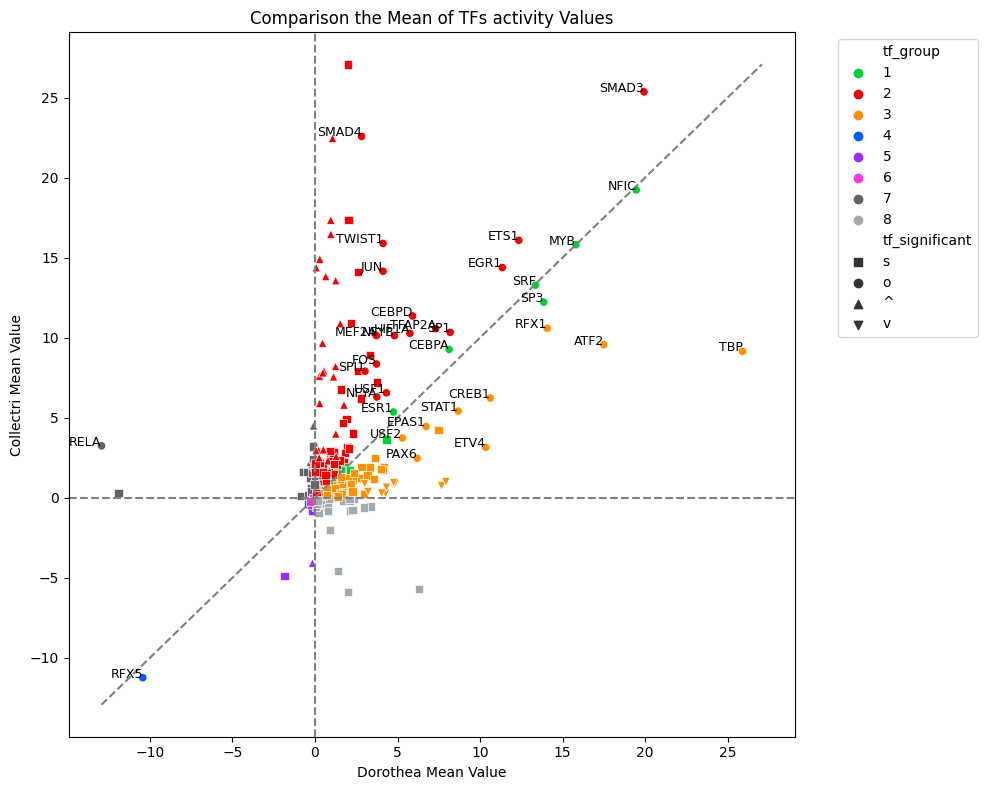

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_result, x="tf_dorothea", y="tf_collectri", hue="tf_group",
                palette=color_dict, style="tf_significant", markers=marker_dict)
# sns.scatterplot(data=merged_result, x="tf_dorothea", y="tf_collectri", hue="TF", palette=color_dict)
# Add TF names as text on the graph
for index, row in merged_result.iterrows():
    if row['tf_significant'] == "o":
        plt.text(row['tf_dorothea'], row['tf_collectri'], row['TF'], fontsize=9, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
# 45-degree line
plt.plot([min(merged_result["tf_dorothea"].min(), merged_result["tf_collectri"].min()),
          max(merged_result["tf_dorothea"].max(), merged_result["tf_collectri"].max())],
         [min(merged_result["tf_dorothea"].min(), merged_result["tf_collectri"].min()),
          max(merged_result["tf_dorothea"].max(), merged_result["tf_collectri"].max())],
         color='gray', linestyle='--')
plt.title("Comparison the Mean of TFs activity Values")
plt.xlabel("Dorothea Mean Value")
plt.ylabel("Collectri Mean Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

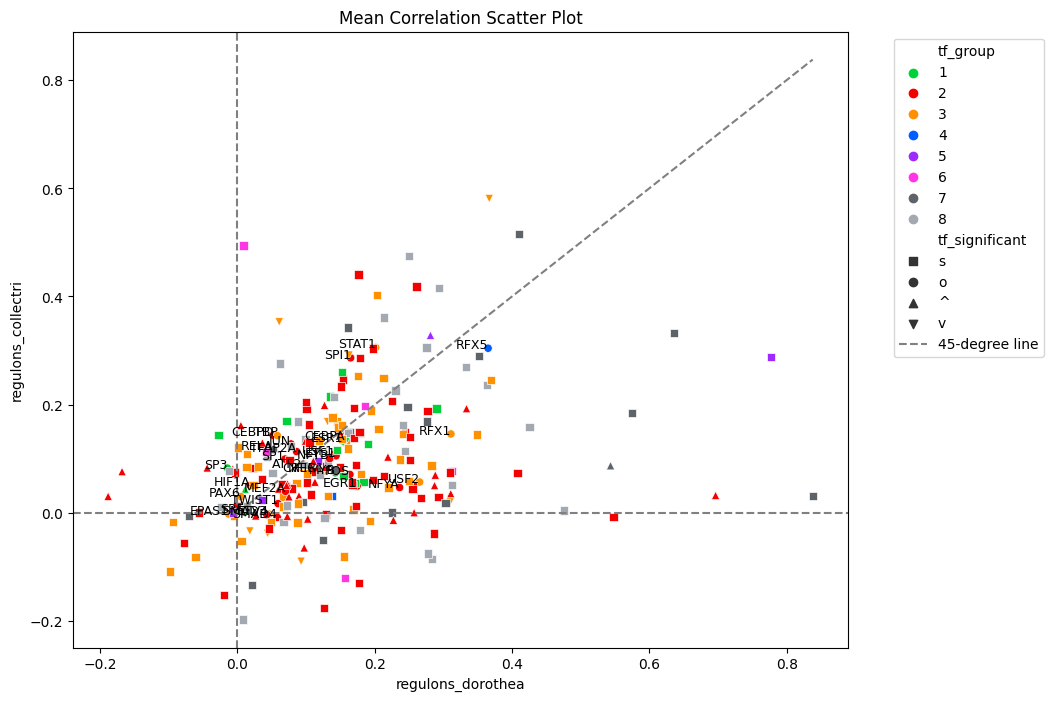

In [ ]:
# Plot the scatter
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_result, x="regulons_dorothea", y="regulons_collectri", hue="tf_group",
                palette=color_dict, legend="full", style="tf_significant", markers=marker_dict)
# sns.scatterplot(data=merged_result, x="regulons_dorothea", y="regulons_collectri", hue="TF", palette=color_dict, legend="full")
# Add TF names as text on the graph
for index, row in merged_result.iterrows():
  if row['tf_significant'] == "o":
    plt.text(row['regulons_dorothea'], row['regulons_collectri'], row['TF'], fontsize=9, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
# Adding the 45-degree line
max_val = max(merged_result["regulons_dorothea"].max(), merged_result["regulons_collectri"].max())
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label="45-degree line")
plt.title("Mean Correlation Scatter Plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


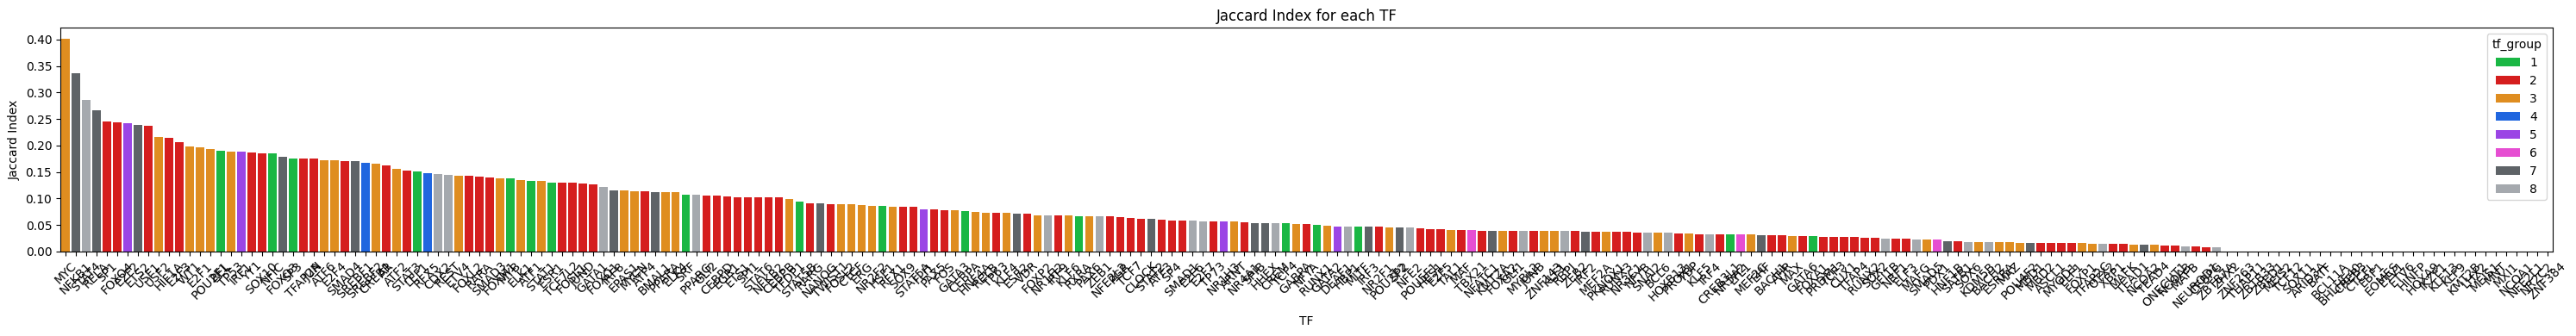

In [ ]:
# 8. Plot bar graph of Jaccard Indices
plt.figure(figsize=(30, 4))
sns.barplot(data=merged_result, x="TF", y="Jaccard Index", hue="tf_group",
            palette=color_dict, dodge=False)
plt.title("Jaccard Index for each TF")
plt.ylabel("Jaccard Index")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

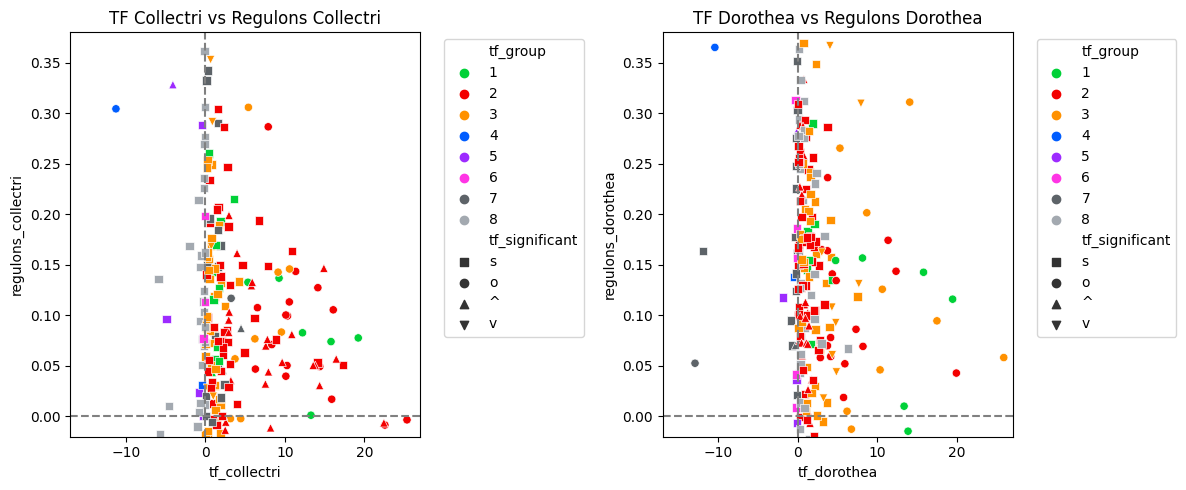

In [ ]:
# Plot the scatter
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Getting the limits for axes
lim = max(abs(merged_result[['tf_collectri', 'tf_dorothea', 'regulons_collectri', 'regulons_dorothea']].values.flatten()))

# Plot for tf_collectri vs regulons_collectri
sns.scatterplot(data=merged_result, x="tf_collectri", y="regulons_collectri",
                hue="tf_group", palette=color_dict, style="tf_significant", markers=marker_dict, ax=axes[0]) # , style="marker", markers=marker_dict
axes[0].set_title("TF Collectri vs Regulons Collectri")
axes[0].legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].axhline(0, color='gray', linestyle='--')
axes[0].axvline(0, color='gray', linestyle='--')
axes[0].set_xlim(-17, 27)
axes[0].set_ylim(-0.02, 0.38)

# Plot for tf_dorothea vs regulons_dorothea
sns.scatterplot(data=merged_result, x="tf_dorothea", y="regulons_dorothea",
                hue="tf_group", palette=color_dict, style="tf_significant", markers=marker_dict, ax=axes[1]) # , style="marker", markers=marker_dict
axes[1].set_title("TF Dorothea vs Regulons Dorothea")
axes[1].legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].axvline(0, color='gray', linestyle='--')
axes[1].set_xlim(-17, 27)
axes[1].set_ylim(-0.02, 0.38)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Dataset 1
x1 = np.array([0.1, 90, 100])
y1 = np.array([-1, 1, 1])

# Dataset 2
x2 = np.array([0.5, 9, 10])
y2 = np.array([-1, 1, 1])

# Linear regression for Dataset 1
slope1 = np.sum((x1 - x1.mean()) * (y1 - y1.mean())) / np.sum((x1 - x1.mean())**2)
y_pred1 = slope1 * x1 + (y1.mean() - slope1 * x1.mean())
residuals1 = y1 - y_pred1
SE_slope1 = np.sqrt(np.sum(residuals1**2) / (len(x1) - 2) / np.sum((x1 - x1.mean())**2))
t_value1 = slope1 / SE_slope1

# Linear regression for Dataset 2
slope2 = np.sum((x2 - x2.mean()) * (y2 - y2.mean())) / np.sum((x2 - x2.mean())**2)
y_pred2 = slope2 * x2 + (y2.mean() - slope2 * x2.mean())
residuals2 = y2 - y_pred2
SE_slope2 = np.sqrt(np.sum(residuals2**2) / (len(x2) - 2) / np.sum((x2 - x2.mean())**2))
t_value2 = slope2 / SE_slope2

t_value1, t_value2


(10.958108109219095, 10.392304845413259)

### **TASK 2** With DEA

In [ ]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=adata_filtered,
    design_factors='condition',
    refit_cooks=True,
    n_cpus=8,
)
dds

AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    obsm: 'design_matrix'
    layers: 'counts'

In [ ]:
# Compute LFCs
dds.deseq2()
dds

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 217.05 seconds.

Fitting dispersion trend curve...
... done in 8.38 seconds.

Fitting MAP dispersions...
... done in 215.03 seconds.

Fitting LFCs...
... done in 13.95 seconds.

Refitting 0 outliers.



AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors'
    varm: 'non_zero', '_rough_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'counts', 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [ ]:
# Extract contrast between treatment vs normal
stat_res = DeseqStats(dds, contrast=["condition", 'treatment', 'control'], n_cpus=8)

# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 4.51 seconds.



Log2 fold change & Wald test p-value: condition treatment vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.067094,0.294257,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.086227,0.249617,-0.345438,0.729765,0.801351
CICP27,106.257057,0.144798,0.177248,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.634443,0.286075,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.579098,0.270626,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.445816,0.278378,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.343227,0.287943,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.323882,0.302438,-1.070903,0.284213,0.387995


In [ ]:
# Shrink LFCs
stat_res.lfc_shrink(coeff='condition_treatment_vs_control')

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition treatment vs control


... done in 30.00 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.050407,0.271447,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.068949,0.234608,-0.345438,0.729765,0.801351
CICP27,106.257057,0.129368,0.172303,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.523892,0.280505,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.483006,0.266258,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.240886,0.260519,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.265368,0.273098,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.523154,0.297741,-1.070903,0.284213,0.387995


In [ ]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.050407,0.271447,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.068949,0.234608,-0.345438,0.729765,0.801351
CICP27,106.257057,0.129368,0.172303,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.523892,0.280505,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.483006,0.266258,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.240886,0.260519,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.265368,0.273098,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.523154,0.297741,-1.070903,0.284213,0.387995


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


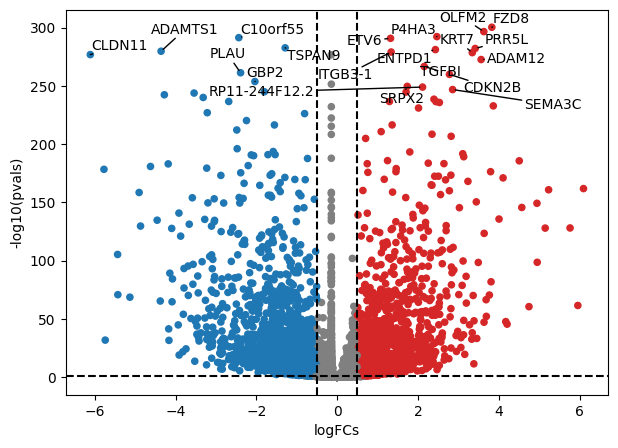

In [ ]:
# Show Vocano Plot
dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=20)

In [ ]:
# Obtain gene level statistics to perform enrichment analysis
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

GeneName,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,AC114498.1,MIR6723,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
treatment.vs.control,0.22801,-0.345438,0.816925,-2.217747,2.139848,-0.422515,-1.373661,-0.53866,-2.845663,-3.862065,...,-1.472827,0.550156,0.704443,1.049607,-1.283784,-1.601475,-1.191996,-1.070903,-1.49019,-2.362806


CollecTRI network

In [ ]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 17575 targets for 629 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91
treatment.vs.control,-1.757384,-2.041384,-1.317279,-2.718626,-2.338566,0.178862,-6.440889,1.410645,2.23343,-0.704304,...,-1.164067,-0.933561,2.687689,1.49982,-1.249087,-1.407577,-0.820753,0.485726,2.157699,0.86518


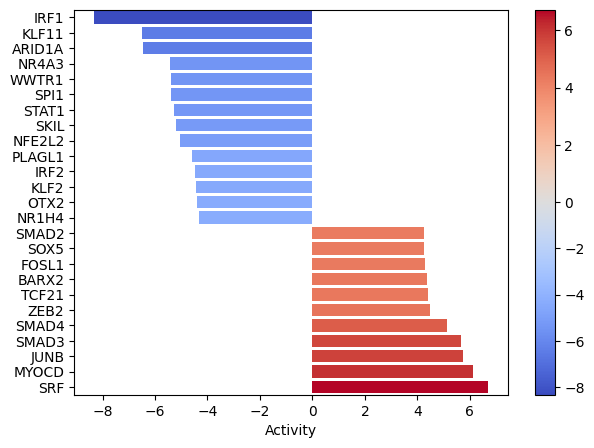

In [ ]:
# Show the obtained scores for the top active/inactive transcription factors
dc.plot_barplot(tf_acts, 'treatment.vs.control', top=25, vertical=True)

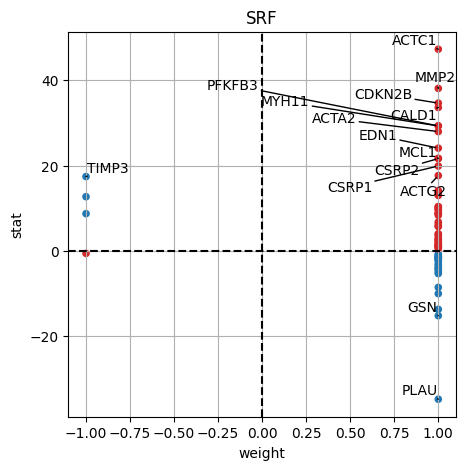

In [ ]:
# Manually inspect the downstream targets of each transcription factor
dc.plot_targets(results_df, stat='stat', source_name='SRF', net=collectri, top=15)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


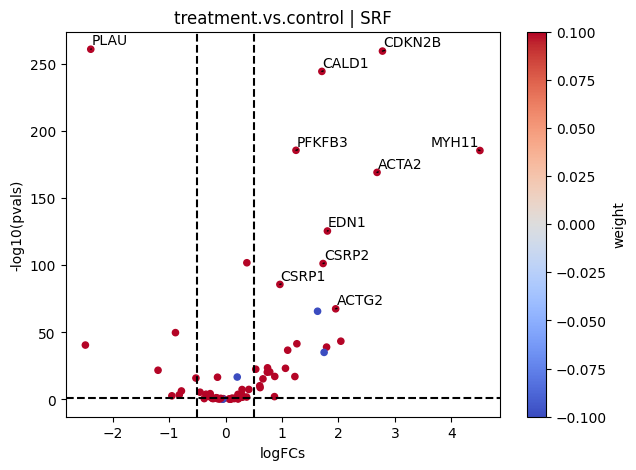

In [ ]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'treatment.vs.control'})
pvals = results_df[['padj']].T.rename(index={'padj': 'treatment.vs.control'})

# Plot
dc.plot_volcano(logFCs, pvals, 'treatment.vs.control', name='SRF', net=collectri, top=10, sign_thr=0.05, lFCs_thr=0.5)